# LLM Evaluation for Generation Tasks

This notebook implements the evaluation pipeline for the two generation tasks: `task_7_diversity_queries` and `task_4_sequential_session`. The goal is to assess how well the LLMs can generate relevant recipe names based on user history or session context.

**Evaluation Metrics:**
Because the output is free-form text, we cannot use simple accuracy. Instead, we will use:
1.  **BERTScore:** Measures the semantic similarity between the generated text and the ground truth using BERT embeddings. It provides a score from 0 to 1, where 1 is a perfect semantic match.
2.  **Keyword Recall:** A simpler metric that checks if the essential recipe names from the ground truth appear anywhere in the LLM's generated text.

**Process:**
1.  **Setup**: Install libraries (including `bert-score`) and initialize the OpenAI API client.
2.  **Helper Functions**: Define core functions for API calls (modified for text output) and result saving.
3.  **Task-by-Task Evaluation**: Run the evaluation for `task_7` and `task_4`, calculating the scores for each prediction.
4.  **Result Saving**: Save detailed results, including scores, to separate JSON files.
5.  **Final Analysis**: Aggregate results and calculate the *average* BERTScore and Keyword Recall for each model on each task.

### 1. Environment Setup

In [ ]:
# NOTE: bert-score requires either PyTorch or TensorFlow. 
# If you don't have torch installed, you might need: %pip install torch
# %pip install openai python-dotenv bert-score transformers matplotlib tqdm pandas

### 2. Imports, API Initialization, and Constants

In [1]:
print("Hello world")

Hello world


In [2]:
import json
import os
import time
import random
import re
from openai import OpenAI
from dotenv import load_dotenv
from bert_score import score as bert_score_calculate
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

# --- API and Model Configuration ---
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# The models we will compare
MODELS_TO_TEST = ["gpt-3.5-turbo", "gpt-4o"]

# Ensure a directory for results exists
os.makedirs('results', exist_ok=True)

# Simple instruction for the LLM to provide concise output
CONCISE_RESPONSE_INSTRUCTION = "\n\nRespond concisely with only the requested information (e.g., recipe name(s))."

### 3. Core Helper Functions

In [3]:
def load_json_file(file_path):
    """Loads a JSON file safely."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return None

def save_results(results, file_path):
    """Saves a list of dictionaries to a JSON file."""
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2)
    print(f"Successfully saved {len(results)} results to {file_path}")

def get_generation_prompt(instruction_input):
    """Builds the prompt for generation tasks."""
    return f"{instruction_input}{CONCISE_RESPONSE_INSTRUCTION}"

def get_llm_generation(client, model_name, prompt):
    """Calls the correct API endpoint and gets the raw text generation."""
    retries = 3
    delay = 5

    for attempt in range(retries):
        try:
            content = None
            if model_name == "gpt-5-pro":
                response = client.completions.create(
                    model=model_name,
                    prompt=prompt,
                    max_tokens=150, # Adjust token limit as needed
                    temperature=0
                )
                content = response.choices[0].text.strip()
            else:
                response = client.chat.completions.create(
                    model=model_name,
                    messages=[{"role": "user", "content": prompt}],
                    # No JSON format needed here
                    temperature=0
                )
                content = response.choices[0].message.content.strip()
            
            # Basic cleaning: remove potential conversational prefixes
            cleaned_content = re.sub(r"^(Here are the recipes:|Okay, the next recipe is|Sure, the recipe is)\s*", "", content, flags=re.IGNORECASE)
            return cleaned_content

        except Exception as e:
            print(f"API Error ({model_name}): {e}. Retrying... (Attempt {attempt + 1}/{retries})")
            time.sleep(delay)
            delay *= 2
            
    return "api_error" # Failed after all retries

def calculate_keyword_recall(prediction, ground_truth):
    """
    Calculates simple recall: does the prediction contain the key recipe names?
    Handles single or multiple comma-separated ground truth recipes.
    Returns 1.0 if all keywords are found, 0.0 otherwise.
    """
    if not prediction or not ground_truth:
        return 0.0
        
    # Split ground truth into individual recipe names, strip whitespace
    true_recipes = [recipe.strip().lower() for recipe in ground_truth.split(',')]
    
    prediction_lower = prediction.lower()
    
    # Check if *all* true recipe names are present in the prediction
    all_found = True
    for recipe in true_recipes:
        if recipe not in prediction_lower:
            all_found = False
            break
            
    return 1.0 if all_found else 0.0

### 4. Main Generation Evaluation Function

This function runs the evaluation for a generation task file. It calls the LLM, then calculates both BERTScore and Keyword Recall for each prediction.

In [4]:
def run_generation_evaluation(client, data_file_path, unique_id_keys, sample_count=None):
    """Runs the full evaluation pipeline for a single generation data file."""
    
    task_name = os.path.basename(data_file_path).split('.')[0]
    results_path = f"results/results_{task_name}.json"
    
    print(f"\n{'='*20} Starting Evaluation for: {task_name} {'='*20}")
    
    # --- Load data and existing results ---
    all_instructions = load_json_file(data_file_path)
    if not all_instructions:
        return

    # --- Sampling Logic ---
    instructions = all_instructions
    if sample_count:
        actual_sample_count = min(sample_count, len(all_instructions))
        random.seed(42)
        instructions = random.sample(all_instructions, actual_sample_count)
        print(f"Original dataset size: {len(all_instructions)}. Using a random sample of {len(instructions)} instructions.")
    else:
        print(f"Using the full dataset of {len(instructions)} instructions.")

    # --- Load existing results ---
    all_results = []
    processed_keys = set()
    if os.path.exists(results_path):
        all_results = load_json_file(results_path)
        for res in all_results:
            key_tuple = (res['model_name'],) + tuple(res[k] for k in unique_id_keys)
            processed_keys.add(key_tuple)
        print(f"Loaded {len(all_results)} existing results. Resuming...")

    api_calls_made = 0
    predictions_to_score = [] # Batch scoring for BERTScore efficiency
    results_buffer = [] # Store results temporarily before scoring

    # --- Main evaluation loop ---
    for model_name in MODELS_TO_TEST:
        print(f"\n--- Processing Model: {model_name} ---")
        
        # Collect predictions for this model
        model_predictions = []
        model_references = []
        model_temp_results = []

        for instruction in tqdm(instructions, desc=f"Model: {model_name}"):
            id_values = [instruction.get(k) for k in unique_id_keys]
            current_key = (model_name,) + tuple(id_values)

            if current_key in processed_keys:
                # Find existing result to get prediction for scoring later
                existing_result = next((r for r in all_results if (r['model_name'] == model_name and all(r[k] == v for k, v in zip(unique_id_keys, id_values)))), None)
                if existing_result:
                    prediction = existing_result.get('llm_prediction', 'api_error')
                else: 
                    continue # Should not happen if key is in processed_keys
            else:
                # Get new prediction
                prompt = get_generation_prompt(instruction['instruction_input'])
                prediction = get_llm_generation(client, model_name, prompt)
                api_calls_made += 1
            
            true_label = instruction['instruction_output']
            
            # Store necessary info for scoring and saving
            temp_record = {
                "model_name": model_name,
                "llm_prediction": prediction,
                "true_label": true_label,
                "timestamp": time.time() if current_key not in processed_keys else None # Add timestamp only for new records
            }
            for key, value in zip(unique_id_keys, id_values):
                temp_record[key] = value

            model_predictions.append(prediction if prediction != 'api_error' else "") # Use empty string for BERTScore on error
            model_references.append(true_label)
            model_temp_results.append(temp_record)
            
            # Add to processed keys immediately if it was a new API call
            if current_key not in processed_keys:
                 processed_keys.add(current_key)


        # --- Calculate BERTScore for this model's predictions ---
        print(f"Calculating BERTScore for {len(model_predictions)} predictions...")
        # Use a pre-trained model suitable for sentence similarity
        # device='cuda:0' if you have GPU, otherwise uses CPU
        P, R, F1 = bert_score_calculate(model_predictions, model_references, lang="en", verbose=False, model_type='microsoft/deberta-xlarge-mnli')

        # --- Combine results with scores and save ---
        for i, record in enumerate(model_temp_results):
            # Only add scores if the prediction was valid
            if record['llm_prediction'] != 'api_error':
                 record['bert_score_f1'] = F1[i].item() # Store the F1 score from BERTScore
                 record['keyword_recall'] = calculate_keyword_recall(record['llm_prediction'], record['true_label'])
            else:
                 record['bert_score_f1'] = None
                 record['keyword_recall'] = 0.0
            
            # Append to all_results only if it's a new record (has a timestamp)
            if record['timestamp'] is not None:
                all_results.append(record)

        # Save progress after each model
        save_results(all_results, results_path)

    print(f"\nTotal new API calls made in this run: {api_calls_made}")
    print(f"\n{'='*20} Evaluation COMPLETE for: {task_name} {'='*20}")

### 5. Evaluation: Task 7 - Diversity Queries

In [12]:
# --- Config for this file ---
DATA_FILE_PATH_7 = 'data/task_7_diversity_queries 1.json'
# We just need user_id to uniquely identify rows here
UNIQUE_ID_KEYS_7 = ['user_id'] 

sample_percentage = 0.5
sample_count = int(sample_percentage * 727)

# --- Run Evaluation ---
run_generation_evaluation(client, DATA_FILE_PATH_7, UNIQUE_ID_KEYS_7, sample_count)


==================== Starting Evaluation for: task_7_diversity_queries 1 ====================
Original dataset size: 727. Using a random sample of 363 instructions.

--- Processing Model: gpt-3.5-turbo ---


Model: gpt-3.5-turbo: 100%|██████████| 363/363 [04:59<00:00,  1.21it/s]


Calculating BERTScore for 363 predictions...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Exception ignored in: <function tqdm.__del__ at 0x0000013C527C5260>
Traceback (most recent call last):
  File "c:\Users\amollaza24\OneDrive - University of Oulu and Oamk\HEALTH-AWARE_FOOD_RECOMMENDATION\healthfood_env\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\amollaza24\OneDrive - University of Oulu and Oamk\HEALTH-AWARE_FOOD_RECOMMENDATION\healthfood_env\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


Successfully saved 363 results to results/results_task_7_diversity_queries 1.json

--- Processing Model: gpt-4o ---


Model: gpt-4o: 100%|██████████| 363/363 [07:47<00:00,  1.29s/it]


Calculating BERTScore for 363 predictions...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Exception ignored in: <function tqdm.__del__ at 0x0000013C527C5260>
Traceback (most recent call last):
  File "c:\Users\amollaza24\OneDrive - University of Oulu and Oamk\HEALTH-AWARE_FOOD_RECOMMENDATION\healthfood_env\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\amollaza24\OneDrive - University of Oulu and Oamk\HEALTH-AWARE_FOOD_RECOMMENDATION\healthfood_env\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


Successfully saved 726 results to results/results_task_7_diversity_queries 1.json

Total new API calls made in this run: 726

==================== Evaluation COMPLETE for: task_7_diversity_queries 1 ====================


### 6. Evaluation: Task 4 - Sequential Session

In [5]:
# --- Config for this file ---
DATA_FILE_PATH_4 = 'data/task_4_sequential_session 1.json'
UNIQUE_ID_KEYS_4 = ['user_id', 'target_recipe_id'] 
sample_percentage = 0.01
sample_count = int(sample_percentage * 100000)

# --- Run Evaluation  ---
run_generation_evaluation(client, DATA_FILE_PATH_4, UNIQUE_ID_KEYS_4, sample_count)


==================== Starting Evaluation for: task_4_sequential_session 1 ====================
Original dataset size: 100000. Using a random sample of 1000 instructions.

--- Processing Model: gpt-3.5-turbo ---


Model: gpt-3.5-turbo: 100%|██████████| 1000/1000 [11:56<00:00,  1.40it/s]


Calculating BERTScore for 1000 predictions...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Exception ignored in: <function tqdm.__del__ at 0x0000024AB2BD54E0>
Traceback (most recent call last):
  File "c:\Users\amollaza24\OneDrive - University of Oulu and Oamk\HEALTH-AWARE_FOOD_RECOMMENDATION\healthfood_env\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\amollaza24\OneDrive - University of Oulu and Oamk\HEALTH-AWARE_FOOD_RECOMMENDATION\healthfood_env\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


Successfully saved 1000 results to results/results_task_4_sequential_session 1.json

--- Processing Model: gpt-4o ---


Model: gpt-4o: 100%|██████████| 1000/1000 [12:10<00:00,  1.37it/s]


Calculating BERTScore for 1000 predictions...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Exception ignored in: <function tqdm.__del__ at 0x0000024AB2BD54E0>
Traceback (most recent call last):
  File "c:\Users\amollaza24\OneDrive - University of Oulu and Oamk\HEALTH-AWARE_FOOD_RECOMMENDATION\healthfood_env\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\amollaza24\OneDrive - University of Oulu and Oamk\HEALTH-AWARE_FOOD_RECOMMENDATION\healthfood_env\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


Successfully saved 2000 results to results/results_task_4_sequential_session 1.json

Total new API calls made in this run: 2000

==================== Evaluation COMPLETE for: task_4_sequential_session 1 ====================


### 7. Final Analysis

This cell loads the results for the generation tasks and calculates the average BERTScore (F1) and average Keyword Recall for each model on each task.

Loaded a total of 2726 scored predictions from 2 result files.


--- 🚀 Final Performance Summary (Average BERTScore F1) ---
| task_name                   |   gpt-3.5-turbo |   gpt-4o |
|:----------------------------|----------------:|---------:|
| task_4_sequential_session 1 |          0.5723 |   0.6270 |
| task_7_diversity_queries 1  |          0.4952 |   0.5024 |


--- 🚀 Final Performance Summary (Average Keyword Recall) ---
| task_name                   |   gpt-3.5-turbo |   gpt-4o |
|:----------------------------|----------------:|---------:|
| task_4_sequential_session 1 |          0.0020 |   0.0010 |
| task_7_diversity_queries 1  |          0.0000 |   0.0000 |


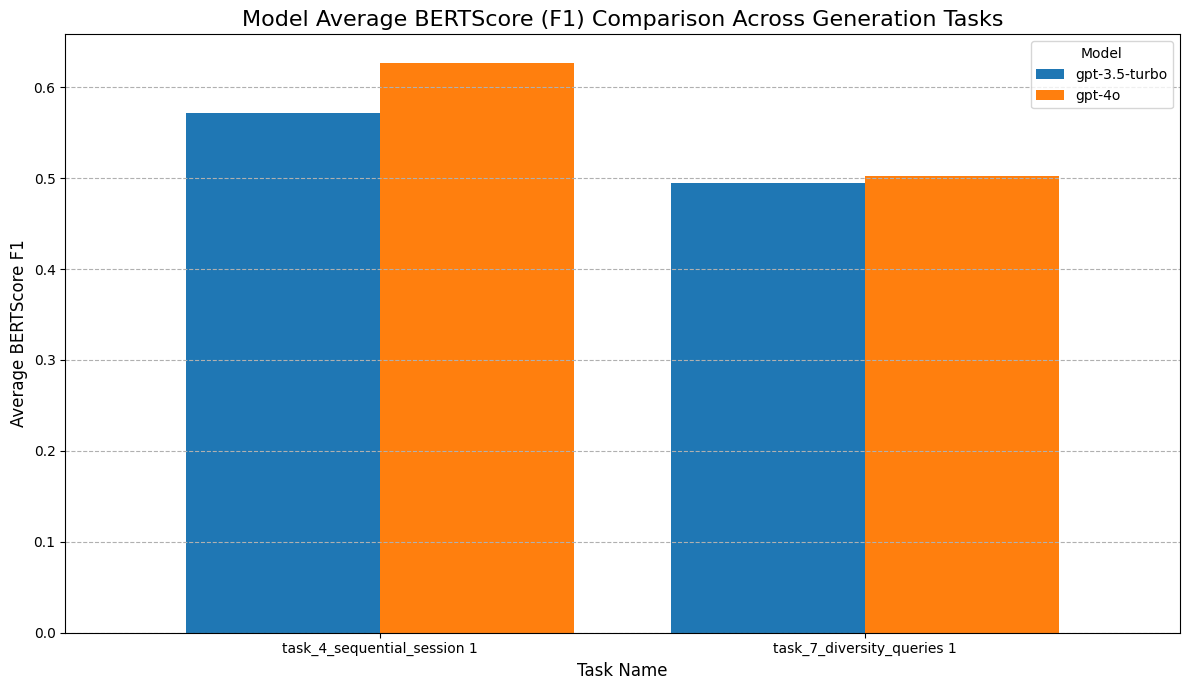

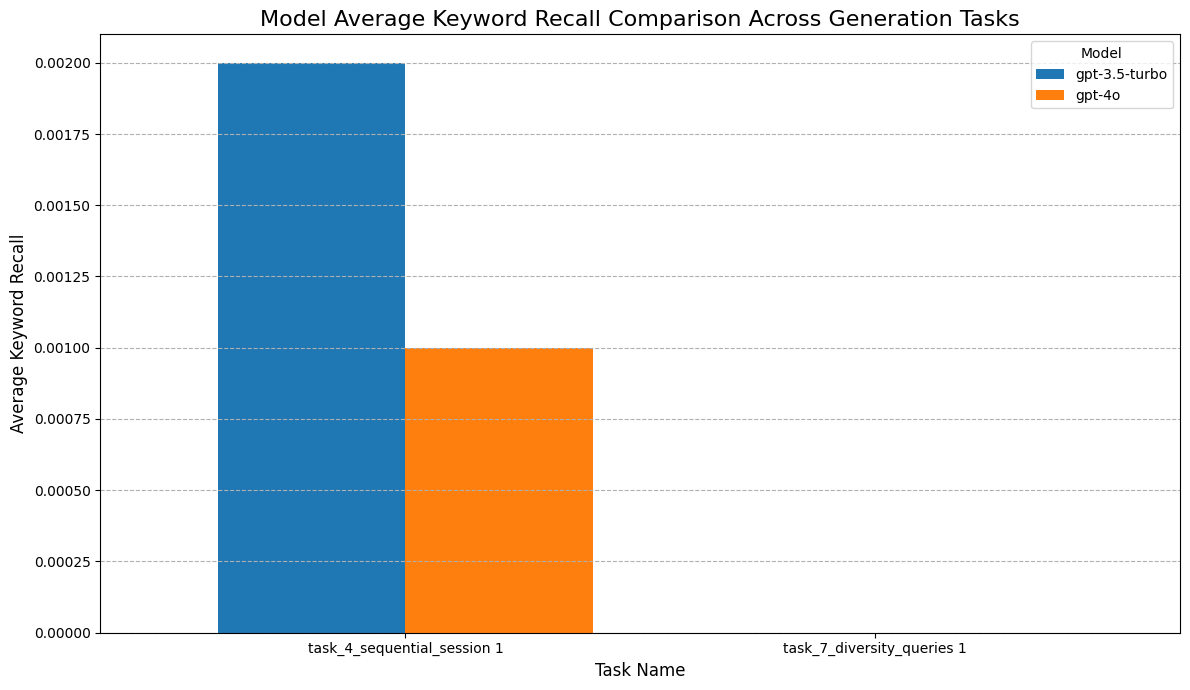

In [6]:
# --- Load all generation result files ---
results_dir = 'results'
all_results_df = []
for filename in os.listdir(results_dir):
    if filename.startswith('results_task_') and filename.endswith('.json'):
        # Only load generation task results
        if any(task_num in filename for task_num in ['task_7', 'task_4']):
            task_name = filename.replace('results_', '').replace('.json', '')
            df = pd.read_json(os.path.join(results_dir, filename))
            df['task_name'] = task_name
            all_results_df.append(df)

if not all_results_df:
    print("No result files found. Please run the generation evaluation cells first.")
else:
    full_df = pd.concat(all_results_df, ignore_index=True)
    # Drop rows where scoring failed (e.g., due to API error on prediction)
    full_df = full_df.dropna(subset=['bert_score_f1']) 
    print(f"Loaded a total of {len(full_df)} scored predictions from {len(all_results_df)} result files.")

    # --- Calculate average scores for each group ---
    summary = full_df.groupby(['task_name', 'model_name']).agg(
        avg_bert_score_f1=('bert_score_f1', 'mean'),
        avg_keyword_recall=('keyword_recall', 'mean')
    ).reset_index()

    # --- Display Summary Tables ---
    print("\n\n--- 🚀 Final Performance Summary (Average BERTScore F1) ---")
    summary_pivot_bert = summary.pivot(index='task_name', columns='model_name', values='avg_bert_score_f1')
    print(summary_pivot_bert.to_markdown(floatfmt=".4f"))

    print("\n\n--- 🚀 Final Performance Summary (Average Keyword Recall) ---")
    summary_pivot_recall = summary.pivot(index='task_name', columns='model_name', values='avg_keyword_recall')
    print(summary_pivot_recall.to_markdown(floatfmt=".4f"))
    
    # --- Display Visualization: BERTScore ---
    summary_pivot_bert.plot(kind='bar', figsize=(12, 7), width=0.8)
    plt.title('Model Average BERTScore (F1) Comparison Across Generation Tasks', fontsize=16)
    plt.ylabel('Average BERTScore F1', fontsize=12)
    plt.xlabel('Task Name', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Model')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # --- Display Visualization: Keyword Recall ---
    summary_pivot_recall.plot(kind='bar', figsize=(12, 7), width=0.8)
    plt.title('Model Average Keyword Recall Comparison Across Generation Tasks', fontsize=16)
    plt.ylabel('Average Keyword Recall', fontsize=12)
    plt.xlabel('Task Name', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Model')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()